In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

from lcs.metrics import population_metrics
from lcs.agents import EnvironmentAdapter
from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.strategies.action_selection2 import BestAction, EpsilonGreedy, ActionDelay, KnowledgeArray

from time import sleep
from copy import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load environments
import gym
import gym_multiplexer

from utils.postprocessing import parse_experiments_results

%matplotlib inline

In [2]:
BINS = 6

ENV_NAME = "real-multiplexer-6bit-v0"

EXPERIMENTS = 5
EXPLORE_TRIALS = 10000
EXPLOIT_TRIALS = 500

In [3]:
env = gym.make(ENV_NAME)

# visualization
env.reset()
env.render()

[0.4469509246722324, 0.8605890442743813, 0.8225131968431008, 0.1981736858840315, 0.30307101160289174, 0.04827680893477915, 0.0]


## Phenotype adapter (discretizer)

In [4]:
_range, _low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)

class RealMultiplxerAdapter(EnvironmentAdapter):
    @classmethod
    def to_genotype(cls, obs):
        r = (obs + np.abs(_low)) / _range
        b = (r * BINS).astype(int)
        return b.astype(str).tolist()

# verify
adapter = RealMultiplxerAdapter()
adapter.to_genotype(env.reset())

['5', '4', '2', '5', '5', '2', '0']

## Metrics

In [5]:
def rmpx_metrics(pop, env):
    metrics = {
        'reliable': len([cl for cl in pop if cl.is_reliable()])
    }
    metrics.update(population_metrics(pop, env))
    return metrics

# Experiments

In [6]:
base_params = {
    "action_selector": EpsilonGreedy,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 4,
    "metrics_trial_frequency": 2,
    "environment_adapter": RealMultiplxerAdapter,
    "user_metrics_collector_fcn": rmpx_metrics
}

In [7]:
def start_single_experiment(**kwargs):
    # Prepare the environment
    env.reset()

    cfg = Configuration(7, 2, **kwargs)
    sleep(1)
    
    explorer = ACS2(cfg)
    population_explore, metrics_explore = explorer.explore(env, EXPLORE_TRIALS)
    
    exploiter = ACS2(cfg, population_explore)
    population_exploit, metrics_exploit = explorer.exploit(env, EXPLOIT_TRIALS)
    
    # Parse results into DataFrame
    df = parse_experiments_results(metrics_explore, metrics_exploit, cfg.metrics_trial_frequency)
    
    return population_exploit, df

In [8]:
def avg_experiments(n, **kwargs):
    dfs = []
    print(f"{kwargs}\n")

    for i in range(n):
        print(f"Executing experiment {i}")
        pop, df = start_single_experiment(**kwargs)
        dfs.append(df)
    
    bar = pd.concat(dfs)
    perf_df = bar.groupby(['trial', 'phase']).mean().reset_index(level='phase')

    return perf_df

## Baseline (epsilon greedy)

In [9]:
# Prepare parameters
epsilon_greedy_params = copy(base_params)

epsilon_greedy_df = avg_experiments(EXPERIMENTS, **epsilon_greedy_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x114fc24d0>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Action Delay Bias

In [10]:
action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(EXPERIMENTS, **action_delay_params)

{'action_selector': <class 'lcs.strategies.action_selection2.ActionDelay.ActionDelay'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x114fc24d0>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Knowledge Array Bias

In [11]:
knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(EXPERIMENTS, **knowledge_array_params)

{'action_selector': <class 'lcs.strategies.action_selection2.KnowledgeArray.KnowledgeArray'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x114fc24d0>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Optimistic initial quality values

In [12]:
op_initial_params = copy(base_params)
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(EXPERIMENTS, **op_initial_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 4, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.RealMultiplxerAdapter'>, 'user_metrics_collector_fcn': <function rmpx_metrics at 0x114fc24d0>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


# Visuazliation

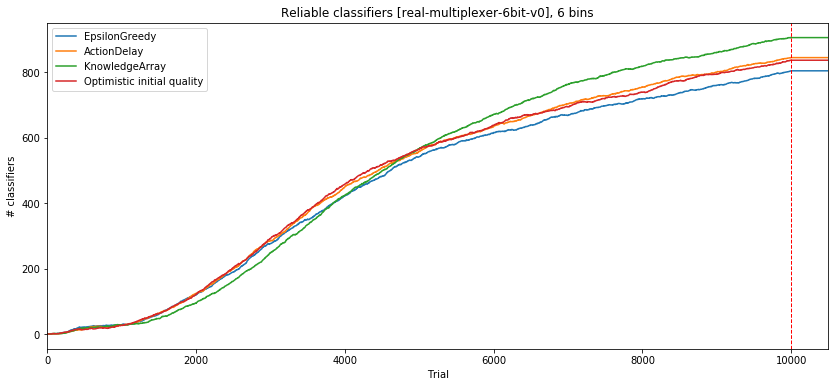

In [13]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['reliable'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['reliable'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['reliable'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['reliable'].plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('# classifiers')
ax.set_title(f'Reliable classifiers [{env.unwrapped.spec.id}], {BINS} bins')
ax.legend()

plt.show()

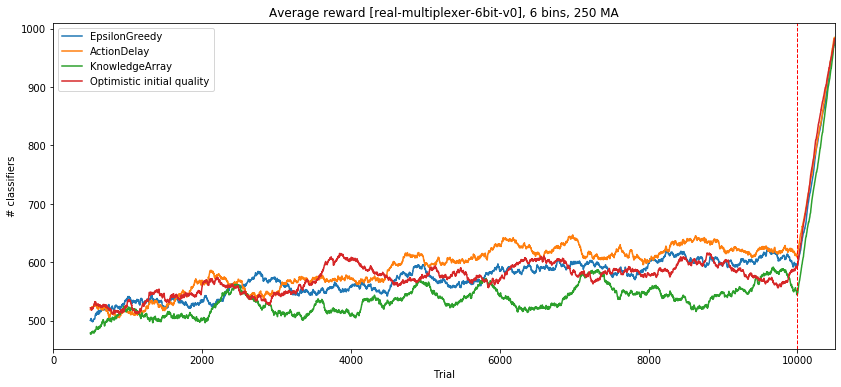

In [14]:
window = 250
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['reward'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['reward'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['reward'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['reward'].rolling(window=window).mean().plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('# classifiers')
ax.set_title(f'Average reward [{env.unwrapped.spec.id}], {BINS} bins, {window} MA')
ax.legend()

plt.show()